In [24]:
import pandas as pd
import numpy as np
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize


# CLEANING TEXT:
import re
import emoji
import spacy # Spacy is an NLP package
nlp = spacy.load('en_core_web_sm')


#NEW baives algo:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# india_count = df['user_location'].str.count('India').sum()
# print('Number of occurrences of India:', india_count)

The data we have spans across 4 months, with the intervals being approximately 15 seconds in between each tweet. Given this, it is intuitive to think that a human being would probably not tweet more than 30 times in 4 months (the average human). The method we have used to be able to distinguish whether a tweet is from a bot or a real human being is based on this, and therefore we look at the frequency of tweets from an account by 'grouping_by' on the "user_name" column.

In [26]:
df = pd.read_csv('../allchatgpt_2.csv')
df.head()

/opt/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Math_Maniac,ChatGPT does ascii art\n#ChatGPT https://t.co/...,"Decatur, GA",I work with a number of tools. Right now it's ...,2020-07-20 14:24:50+00:00,467,1233,49216,FALSE,2023-04-02 13:44:07+00:00,['ChatGPT'],Twitter Web App
1,SmashKoders,#ChatGPT is funny sometimes 😅 https://t.co/cSa...,Mumbai,My life changed while debugging code 😊,2022-06-18 04:34:18+00:00,8,126,239,FALSE,2023-04-02 13:43:46+00:00,['ChatGPT'],Twitter Web App
2,Andreas Illenseer,Let’s put it in graphic terms. Drawing a #Unic...,"Mainz, Deutschland",Specialized in Regulatory & Digital Intelligen...,2017-10-31 19:35:24+00:00,63,188,88,FALSE,2023-04-02 13:43:36+00:00,['Unicorn'],Twitter for iPhone
3,Bitone Great,🔥#Buy!🔥\n🔥RSI below 15!🔥\n[#Bybit]\n⬆ Recommen...,NaN,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1093,492,47,FALSE,2023-04-02 13:43:30+00:00,"['Buy', 'Bybit', 'Long', 'DODOUSDT']",rsi1
4,The Media Scoop,Italian data protection agency placed an immed...,India,Independent news aggregator & YouTuber at The ...,2023-03-07 01:51:53+00:00,0,37,0,FALSE,2023-04-02 13:42:56+00:00,NaN,Twitter Web App


### How does the user_name column look?:

In [27]:
display(df['user_name'].value_counts().describe())
display(df['user_name'].value_counts().median())

count    133571.000000
mean          2.289606
std          17.768623
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4570.000000
Name: user_name, dtype: float64

1.0

As we can see, the majority of the column is closer to that 1-2 mark, and the median = 1 (middle of the values is a human most likely)

### Here we create a new column called 'marker', which is "Yes" if they are a bot, or "No" if they are human:

In [28]:
threshold_for_bot = 20


counts = df.groupby('user_name')['user_name'].transform('count')
df['marker'] = np.where(counts > threshold_for_bot, 'Yes', 'No')

Groupby the column and only display the column:

In [29]:
df.groupby('marker')['marker'].count()

marker
No     235537
Yes     70330
Name: marker, dtype: int64

According to the 30 threshold, you get approximately 60,000 tweets that are from bots out of the 303,000~~

### The columns that contain numeric values supposedly were actually strings, therefore we need to convert them to floats, however we must use pd.to_numeric first:

In [30]:
df['user_followers'].dtypes

dtype('O')

In [31]:
df['user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce')
df['user_friends'] = pd.to_numeric(df['user_friends'], errors='coerce')
df['user_favourites'] = pd.to_numeric(df['user_favourites'], errors='coerce')


#TRY AGAIN:
df['user_followers'].dtypes

dtype('float64')

As we can see above, now the type is float so we can work with it ^^

In [32]:
#Set the index of the DF To marker (to sort by bots and not bots)
df2 = df.set_index('marker')

#Then create new df's based on the Bots and Non-Bots
bots = df2.loc['Yes'].reset_index()
nonbots = df2.loc['No'].reset_index()

Displaying medians below, you can see that the bots have more followers:

In [33]:
display(bots['user_followers'].median())
display(nonbots['user_followers'].median())

476.0

323.0

## When looking at the raw distributions, it's extremely hard to make a conclusion due to the extreme outliers, therefore we winsorize to the 5% and 95% percentiles:

In [34]:
limits = 0.05

bots['w_followers'] = winsorize(bots['user_followers'], limits=[limits, limits])
nonbots['w_followers'] = winsorize(nonbots['user_followers'], limits=[limits, limits])

bots['w_friends'] = winsorize(bots['user_friends'], limits=[limits, limits])
nonbots['w_friends'] = winsorize(nonbots['user_friends'], limits=[limits, limits])


Dropping outliers completely:

In [35]:
p = 0.9
u = 0.05


p_value = bots['user_followers'].quantile(p)
u_value = bots['user_followers'].quantile(u)


bots_dropped = bots['user_followers'].loc[bots['user_followers']<p_value]

nonbots_dropped = nonbots['user_followers'].loc[nonbots['user_followers']<p_value]

bots_dropped_friend = bots['user_friends'].loc[bots['user_friends']<p_value]

nonbots_dropped_friend = nonbots['user_friends'].loc[nonbots['user_friends']<p_value]


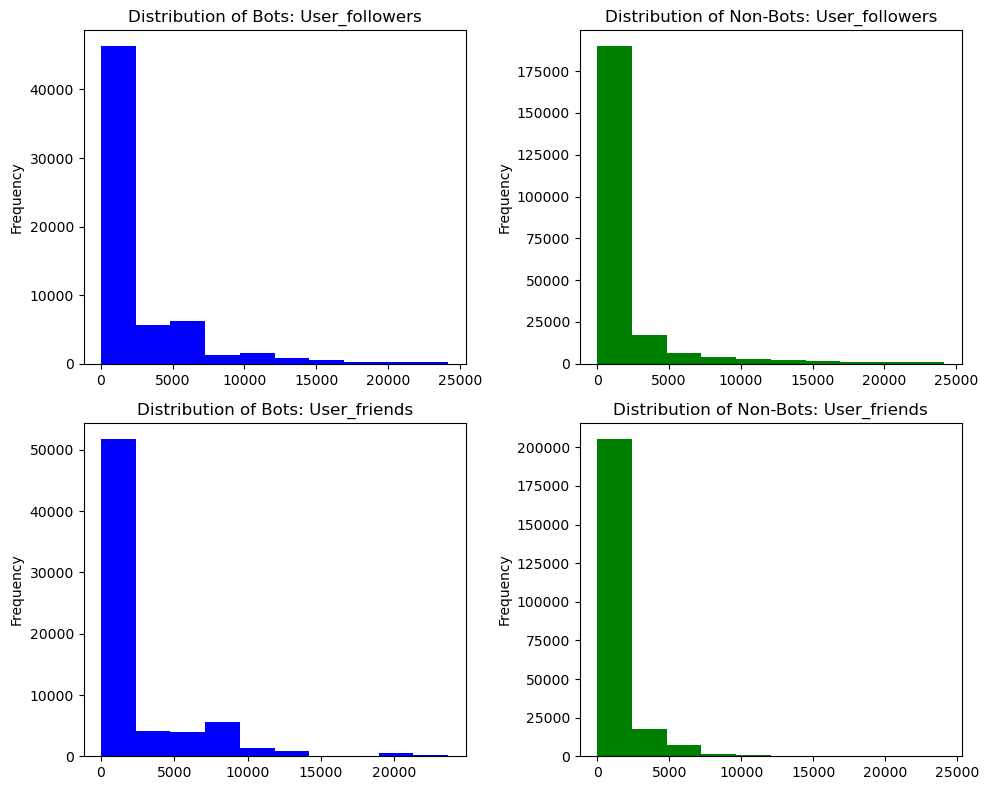

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

bots_dropped.plot(kind='hist', color='blue', title='Distribution of Bots: User_followers', ax=axs[0, 0])
nonbots_dropped .plot(kind='hist', color='green', title='Distribution of Non-Bots: User_followers', ax=axs[0, 1])
bots_dropped_friend.plot(kind='hist', color='blue', title='Distribution of Bots: User_friends', ax=axs[1, 0])
nonbots_dropped_friend.plot(kind='hist', color='green', title='Distribution of Non-Bots: User_friends', ax=axs[1, 1])

plt.tight_layout()
plt.show()


### Seeing the distributions of particular values between each df:

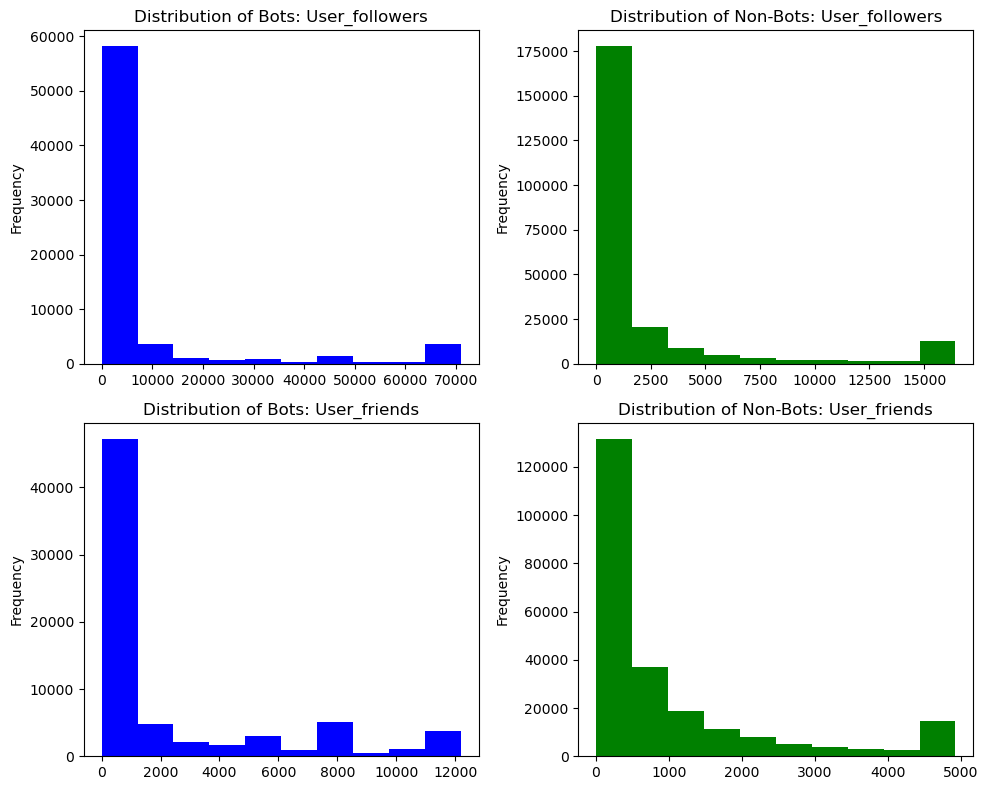

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

bots['w_followers'].plot(kind='hist', color='blue', title='Distribution of Bots: User_followers', ax=axs[0, 0])
nonbots['w_followers'].plot(kind='hist', color='green', title='Distribution of Non-Bots: User_followers', ax=axs[0, 1])
bots['w_friends'].plot(kind='hist', color='blue', title='Distribution of Bots: User_friends', ax=axs[1, 0])
nonbots['w_friends'].plot(kind='hist', color='green', title='Distribution of Non-Bots: User_friends', ax=axs[1, 1])

plt.tight_layout()
plt.show()


Even from the graphs above, there is quite an unusual progression of user_followers and friends. As the number increases, you should see the frequency gradually which you do for the non-bot sample. The bots show a much weirder progression, with random spikes. This is a good way to illustrate the irregular distribution.

### Create several samples of the non-bots given the higher sampler size:

In [38]:
#Generate samples
n_samples = 60000

nonbot_sample_test = pd.DataFrame()

for i in range(1,6):
    col_name = f'Nonbots Sample #{i}'
    np.random.seed(i) # Ensuring a new sample each time
    nonbot_sample_test[col_name] = nonbots['w_followers'].sample(n=n_samples).values

In [39]:
display(print(nonbot_sample_test.describe()))
nonbot_sample_test.hvplot(kind='hist', width = 200, height = 200, title = 'Density Plot between Bots & Non-Bots', alpha = 0.9, subplots = True)

       Nonbots Sample #1  Nonbots Sample #2  Nonbots Sample #3  \
count       60000.000000       60000.000000         60000.0000   
mean         2057.735400        2051.370350          2065.6285   
std          4113.139317        4116.410694          4123.7643   
min             3.000000           3.000000             3.0000   
25%            55.000000          55.000000            53.0000   
50%           327.000000         320.000000           322.0000   
75%          1600.000000        1583.250000          1604.0000   
max         16433.000000       16433.000000         16433.0000   

       Nonbots Sample #4  Nonbots Sample #5  
count       60000.000000       60000.000000  
mean         2077.056983        2027.397067  
std          4138.535536        4080.756167  
min             3.000000           3.000000  
25%            55.000000          54.000000  
50%           330.000000         319.000000  
75%          1603.250000        1556.000000  
max         16433.000000       16433.

None

:NdLayout   [Default]
   :Histogram   [Nonbots Sample #5]   (Nonbots Sample #5_count)

In [40]:
combo = pd.concat([bots['w_followers'], nonbot_sample_test['Nonbots Sample #1']], axis =1)
combo.columns = ['Bots','Nonbots #1 Sample']
combo.hvplot(kind='kde', width = 1000, height = 500, title = 'Density Plot between Bots & Non-Bots', alpha = 0.35, color = ['blue', 'red','yellow'])

:NdOverlay   [Variable]
   :Distribution   [value]   (Density)

The main point of this graph is to illustrate that the dispersion of bot user_followers is much wider than the dispersion of non_bots. This is line with intuition as the bot sample is much more random.

<br><br><br>

## Sentiment Part:

In [41]:
def cleanTweets(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text

In [42]:
bots['clean_text'] = bots['text'].apply(cleanTweets) 
nonbots['clean_text'] = nonbots['text'].apply(cleanTweets)

This function performs text normalization by removing stopwords, punctuation, and lemmatizing the remaining tokens:

In [44]:
def text_preprocessing1(text):
    return ' '.join(token.lemma_.lower() for token in nlp(text) if not token.is_punct)

In [45]:
def text_preprocessing2(text):
    return ' '.join(token.lemma_.lower() for token in nlp(text) if not token.is_stop)

In [49]:
#This may take ALONG TIME TO RUN

#nonbots['clean_text'] = nonbots['clean_text'].apply(text_preprocessing1)
#nonbots['clean_text'] = nonbots['clean_text'].apply(text_preprocessing2)

CountVectorizer converts a text "hello i am x" to a matrix of token counts: [[0 1 1 1 1 1 0 0 0 0]]<br><br>**The Multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).**

# Model:

In [47]:
def model(data, model):
    X = data['clean_text']
    y = data['INSERT_VALUES_THAT_ARE_GIVEN_FROM_VADER']

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,shuffle=True,stratify=y)


##### CREATE MODEL #####
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test)

# IN-SAMPLE:
    model = model
    model.fit(X_train,y_train)
    in_sample_score = model.score(X_train,y_train)

#OOS:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)

#result OOS:
    report = classification_report(y_test, y_pred)


    return print(f'in-sample={in_sample_score}, oos accuracy={accuracy}'), report